Taken from the official Numpy Tutorials: https://github.com/numpy/numpy-tutorials/blob/main/content/tutorial-deep-learning-on-mnist.md

## Table of Contents

1. Load the MNIST dataset
2. Preprocess the dataset
3. Build and train a small neural network from scratch
4. Next steps

<hr>

# 1. Load the MNIST Dataset

In this section, you will download the zipped MNIST dataset files originally stored in <a href="http://yann.lecun.com/exdb/mnist/"> Yann LeCun's website</a>. Then, you will transform them into 4 files of NumPy array type using built-in Python modules. Finally, you will split the arrays into training and test sets.

1. Define a variable to store the training/test image/label names of the MNIST dataset in a list:

In [1]:
data_sources = {
    "training_images": "train-images-idx3-ubyte.gz",  # 60,000 training images.
    "test_images": "t10k-images-idx3-ubyte.gz",  # 10,000 test images.
    "training_labels": "train-labels-idx1-ubyte.gz",  # 60,000 training labels.
    "test_labels": "t10k-labels-idx1-ubyte.gz",  # 10,000 test labels.
}

2. Load the data. First check if the data is stored locally; if not, then download it.

In [2]:
# Use responsibly! When running notebooks locally, be sure to keep local
# copies of the datasets to prevent unnecessary server requests
headers = {
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64; rv:10.0) Gecko/20100101 Firefox/10.0"
}
request_opts = {
    "headers": headers,
    "params": {"raw": "true"},
}

In [3]:
import requests
import os

data_dir = "../../_data"
os.makedirs(data_dir, exist_ok=True)

base_url = "https://github.com/rossbar/numpy-tutorial-data-mirror/blob/main/"

for fname in data_sources.values():
    fpath = os.path.join(data_dir, fname)
    if not os.path.exists(fpath):
        print("Downloading file: " + fname)
        resp = requests.get(base_url + fname, stream=True, **request_opts)
        resp.raise_for_status()  # Ensure download was succesful
        with open(fpath, "wb") as fh:
            for chunk in resp.iter_content(chunk_size=128):
                fh.write(chunk)

3. Decompress the 4 files and create 4 `ndarrays`, saving them into a dictionary. Each original image is of size 28x28 and neural networks normally expect a 1D vector input; therefore you need to reshape the images by multiplying 28x28 (784).

In [4]:
import gzip
import numpy as np

mnist_dataset = {}

# Images
for key in ("training_images", "test_images"):
    with gzip.open(os.path.join(data_dir, data_sources[key]), "rb") as mnist_file:
        mnist_dataset[key] = np.frombuffer(
            mnist_file.read(), np.uint8, offset=16
        ).reshape(-1, 28 * 28)
# Labels
for key in ("training_labels", "test_labels"):
    with gzip.open(os.path.join(data_dir, data_sources[key]), "rb") as mnist_file:
        mnist_dataset[key] = np.frombuffer(mnist_file.read(), np.uint8, offset=8)

4. Split the data into training and test sets using the standard notation of `x` for data and `y` for labels, calling the training and test set images `x_train` and `x_test`, and the labels `y_train` and `y_test`:

In [5]:
x_train, y_train, x_test, y_test = (
    mnist_dataset["training_images"],
    mnist_dataset["training_labels"],
    mnist_dataset["test_images"],
    mnist_dataset["test_labels"],
)

5. You can confirm that the shape of the image arrays is `(60000, 784)` and `(10000, 784)` for training and test sets, respectively, and the labels — `(60000,)` and `(10000,)`:

In [6]:
print("The shape of training images: {} and training labels: {}".format(x_train.shape, y_train.shape))
print("The shape of test images: {} and test labels: {}".format(x_test.shape, y_test.shape))

The shape of training images: (60000, 784) and training labels: (60000,)
The shape of test images: (10000, 784) and test labels: (10000,)


6. And you can inspect some images using Matplotlib:

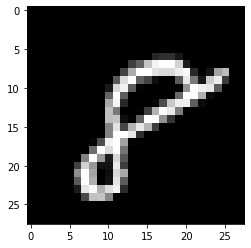

In [7]:
import matplotlib.pyplot as plt

# Take the 60,000th image (indexed at 59,999) from the training set,
# reshape from (784, ) to (28, 28) to have a valid shape for displaying purposes.
mnist_image = x_train[59999, :].reshape(28, 28)
# Set the color mapping to grayscale to have a black background.
plt.imshow(mnist_image, cmap="gray")
# Display the image.
plt.show()

In [8]:
# Display the label of the 60,000th image (indexed at 59,999) from the training set.
y_train[59999]

8

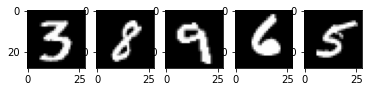

In [9]:
# Display 5 random images from the training set.
num_examples = 5
seed = 147197952744
rng = np.random.default_rng(seed)

fig, axes = plt.subplots(1, num_examples)
for sample, ax in zip(rng.choice(x_train, size=num_examples, replace=False), axes):
    ax.imshow(sample.reshape(28, 28), cmap="gray")

# 2. Preprocess the data

<hr>

Neural networks can work with inputs that are in a form of tensors (multidimensional arrays) of floating-point type. When preprocessing the data, you should consider the following processes: <a href="https://en.wikipedia.org/wiki/Vectorization_%28mathematics%29">vectorization</a> and <a href="https://en.wikipedia.org/wiki/Floating-point_arithmetic#Floating-point_numbers">conversion to a floating point format.</a>

Since the MNIST data is already vectorized and the arrays are of `dtype` `uint8`, your next challenge is to convert them to a floating-point format, such as `float64` (<a href="https://en.wikipedia.org/wiki/Double-precision_floating-point_format">double-precision</a>):

* _Normalizing_ the image data: a [feature scaling](https://en.wikipedia.org/wiki/Feature_scaling#Application) procedure that can speed up the neural network training process by standardizing the [distribution of your input data](https://arxiv.org/pdf/1502.03167.pdf).
* _[One-hot/categorical encoding](https://en.wikipedia.org/wiki/One-hot)_ of the image labels.

In practice, you can use different types of floating-point precision depending on your goals and you can find more information about that in the [Nvidia](https://blogs.nvidia.com/blog/2019/11/15/whats-the-difference-between-single-double-multi-and-mixed-precision-computing/) and [Google Cloud](https://cloud.google.com/blog/products/ai-machine-learning/bfloat16-the-secret-to-high-performance-on-cloud-tpus) blog posts.

### Convert the image data to the floating-point format

The images data contain 8-bit integers encoded in the [0, 255] interval with color values between 0 and 255.

You will normalize them into floating-point arrays in the [0, 1] interval by dividing them by 255.

**1.** Check that the vectorized image data has type `uint8`:

In [10]:
print("The data type of training images: {}".format(x_train.dtype))
print("The data type of test images: {}".format(x_test.dtype))

The data type of training images: uint8
The data type of test images: uint8


**2.** Normalize the arrays by dividing them by 255 (and thus promoting the data type from `uint8` to `float64`) and then assign the train and test image data variables — `x_train` and `x_test` — to `training_images` and `train_labels`, respectively.
To reduce the model training and evaluation time in this example, only a subset
of the training and test images will be used.
Both `training_images` and `test_images` will contain only 1,000 samples each out
of the complete datasets of 60,000 and 10,000 images, respectively.
These values can be controlled by changing the  `training_sample` and
`test_sample` below, up to their maximum values of 60,000 and 10,000.

In [11]:
training_sample, test_sample = 1000, 1000
training_images = x_train[0:training_sample] / 255
test_images = x_test[0:test_sample] / 255

**3.** Confirm that the image data has changed to the floating-point format:

In [12]:
print("The data type of training images: {}".format(training_images.dtype))
print("The data type of test images: {}".format(test_images.dtype))

The data type of training images: float64
The data type of test images: float64


> **Note:** You can also check that normalization was successful by printing `training_images[0]` in a notebook cell. Your long output should contain an array of floating-point numbers:
>
> ```
> ...
>        0.        , 0.        , 0.01176471, 0.07058824, 0.07058824,
>        0.07058824, 0.49411765, 0.53333333, 0.68627451, 0.10196078,
>        0.65098039, 1.        , 0.96862745, 0.49803922, 0.        ,
> ...
> ```

### Convert the labels to floating point through categorical/one-hot encoding

You will use one-hot encoding to embed each digit label as an all-zero vector with `np.zeros()` and place `1` for a label index. As a result, your label data will be arrays with `1.0` (or `1.`) in the position of each image label.

Since there are 10 labels (from 0 to 9) in total, your arrays will look similar to this:


```
array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
```


**1.** Confirm that the image label data are integers with `dtype` `uint8`:

In [13]:
print("The data type of training labels: {}".format(y_train.dtype))
print("The data type of test labels: {}".format(y_test.dtype))

The data type of training labels: uint8
The data type of test labels: uint8


**2.** Define a function that performs one-hot encoding on arrays:

In [14]:
def one_hot_encoding(labels, dimension=10):
    # Define a one-hot variable for an all-zero vector
    # with 10 dimensions (number labels from 0 to 9).
    one_hot_labels = labels[..., None] == np.arange(dimension)[None]
    # Return one-hot encoded labels.
    return one_hot_labels.astype(np.float64)

**3.** Encode the labels and assign the values to new variables:

In [15]:
training_labels = one_hot_encoding(y_train[:training_sample])
test_labels = one_hot_encoding(y_test[:test_sample])


**4.** Check that the data type has changed to floating point:


In [16]:
print("The data type of training labels: {}".format(training_labels.dtype))
print("The data type of test labels: {}".format(test_labels.dtype))

The data type of training labels: float64
The data type of test labels: float64


**5.** Examine a few encoded labels:

In [17]:
print(training_labels[0])
print(training_labels[1])
print(training_labels[2])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


...and compare to the originals:


In [18]:
print(y_train[0])
print(y_train[1])
print(y_train[2])

5
0
4



You have finished preparing the dataset.

# UPLOAD THE DATASET TO A DOMAIN NODE

In [23]:
from syft import Worker, Dataset, Asset
from syft.client.client import SyftClient

In [20]:
w = Worker()
client = SyftClient.from_node(w).login(email="info@openmined.org", password="changethis")

> Worker: Loving Wolf - 4c87a086e77e458c95e79e74eb685857 - NodeType.DOMAIN

Services:
ActionService
DataSubjectMemberService
DataSubjectService
DatasetService
MessageService
MetadataService
NetworkService
PolicyService
ProjectService
RequestService
UserCodeService
UserService


In [52]:
dataset = Dataset(name="MNIST")

In [53]:
dataset.set_description(
    """Modified National Institute of Standards and Technology (MNIST) database containing 60,000 training images and 10,000 testing images of size 28x28"""
)

In [54]:
training_img_asset = Asset(name="training_images", data=training_images, mock=training_images, mock_is_real=True, description="60k images")
# training_img_asset.set_obj(training_images)
# training_img_asset.set_mock(training_images, mock_is_real=True)

In [55]:
training_labels_asset = Asset(name="training_labels", data=training_labels, mock=training_labels, mock_is_real=True, description="60k numbers")
# training_labels_asset.set_obj(training_labels)
# training_labels_asset.set_mock(training_labels, mock_is_real=True)

In [56]:
test_img_asset = Asset(name="test_images", data=test_images, mock=test_images, mock_is_real=True, description="10k test images")
# test_img_asset.set_obj(test_images)
# test_img_asset.set_mock(test_images, mock_is_real=True)

In [57]:
test_labels_asset = Asset(name="test_labels", data=test_labels, mock=test_labels, mock_is_real=True, description="10k numbers")
# test_labels_asset.set_obj(test_labels)
# test_labels_asset.set_mock(test_labels, mock_is_real=True)

In [58]:
dataset.add_asset(training_img_asset)

In [59]:
dataset

```python
Syft Dataset: MNIST
Assets:
	training_images: 60k images
Description: Modified National Institute of Standards and Technology (MNIST) database containing 60,000 training images and 10,000 testing images of size 28x28

```

In [30]:
dataset.add_asset(training_img_asset)

In [60]:
dataset.add_asset(training_labels_asset)

In [61]:
dataset.add_asset(test_img_asset)

In [62]:
dataset.add_asset(test_labels_asset)

In [30]:
dataset.add_asset(training_img_asset)

In [63]:
dataset

```python
Syft Dataset: MNIST
Assets:
	training_images: 60k images
	training_labels: 60k numbers
	test_images: 10k test images
	test_labels: 10k numbers
Description: Modified National Institute of Standards and Technology (MNIST) database containing 60,000 training images and 10,000 testing images of size 28x28

```

In [64]:
client.upload_dataset(dataset)

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 30.52it/s]


Uploading: training_images
Uploading: training_labels
Uploading: test_images
Uploading: test_labels


<class 'syft.service.response.SyftError'>: Duplication Key Error: syft.service.dataset.dataset.Dataset

In [65]:
client.datasets

,type,id,name,url
0,syft.service.dataset.dataset.Dataset,842544b52f664996aa200f744cfb9109,MNIST,None


In [66]:
client.datasets[0]

```python
Syft Dataset: MNIST
Assets:
	training_images: None
	test_images: None
	training_labels: None
	test_labels: None
Description: Modified National Institute of Standards and Technology (MNIST) database containing 60,000 training images and 10,000 testing images of size 28x28

```

In [67]:
client.datasets[0].assets

,key,type,id
0,training_images,syft.service.dataset.dataset.Asset,0fc35aac01494f39b537e33cf38c9243
1,test_images,syft.service.dataset.dataset.Asset,d73a2a4cf0df45dabe03a3664cd3d784
2,training_labels,syft.service.dataset.dataset.Asset,19993e67739d4d3d943eea3a88845413
3,test_labels,syft.service.dataset.dataset.Asset,208cc95368a74c3d99ea16a762a3e8d5


In [69]:
client.datasets[0].assets["training_images"]

```python
Asset: training_images
Pointer Id: 929cf308d2bd41b7b61b4e9b1acc1108
Description: None
Total Data Subjects: 0
Shape: (1000, 784)
Contributors: 0

```

<hr>


## 3. Build and train a small neural network from scratch

In this section you will familiarize yourself with some high-level concepts of the basic building blocks of a deep learning model. You can refer to the original [Deep learning](http://www.cs.toronto.edu/~hinton/absps/NatureDeepReview.pdf) research publication for more information.

Afterwards, you will construct the building blocks of a simple deep learning model in Python and NumPy and train it to learn to identify handwritten digits from the MNIST dataset with a certain level of accuracy.

### Neural network building blocks with NumPy

- _Layers_: These building blocks work as data filters — they process data and learn representations from inputs to better predict the target outputs.

    You will use 1 hidden layer in your model to pass the inputs forward (_forward propagation_) and propagate the gradients/error derivatives of a loss function backward (_backpropagation_). These are input, hidden and output layers.

    In the hidden (middle) and output (last) layers, the neural network model will compute the weighted sum of inputs. To compute this process, you will use NumPy's matrix multiplication function (the "dot multiply" or `np.dot(layer, weights)`).

    > **Note:** For simplicity, the bias term is omitted in this example (there is no `np.dot(layer, weights) + bias`).

- _Weights_: These are important adjustable parameters that the neural network fine-tunes by forward and backward propagating the data. They are optimized through a process called [gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent). Before the model training starts, the weights are randomly initialized with NumPy's [`Generator.random()`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.random.html).

    The optimal weights should produce the highest prediction accuracy and the lowest error on the training and test sets.

- _Activation function_: Deep learning models are capable of determining non-linear relationships between inputs and outputs and these [non-linear functions](https://en.wikipedia.org/wiki/Activation_function) are usually applied to the output of each layer.

    You will use a [rectified linear unit (ReLU)](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) to the hidden layer's output (for example, `relu(np.dot(layer, weights))`.

- _Regularization_: This [technique](https://en.wikipedia.org/wiki/Regularization_(mathematics)) helps prevent the neural network model from [overfitting](https://en.wikipedia.org/wiki/Overfitting).

    In this example, you will use a method called dropout — [dilution](https://en.wikipedia.org/wiki/Dilution_(neural_networks)) — that randomly sets a number of features in a layer to 0s. You will define it with NumPy's [`Generator.integers()`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.integers.html) method and apply it to the hidden layer of the network.

- _Loss function_: The computation determines the quality of predictions by comparing the image labels (the truth) with the predicted values in the final layer's output.

    For simplicity, you will use a basic total squared error using NumPy's `np.sum()` function (for example, `np.sum((final_layer_output - image_labels) ** 2)`).

- _Accuracy_: This metric measures the accuracy of the network's ability to predict on the data it hasn't seen.

### Model architecture and training summary

Here is a summary of the neural network model architecture and the training process:


![Diagram showing operations detailed in this tutorial (The input image
is passed into a Hidden layer that creates a weighted sum of outputs.
The weighted sum is passed to the Non-linearity, then regularization and
into the output layer. The output layer creates a prediction which can
then be compared to existing data. The errors are used to calculate the
loss function and update weights in the hidden layer and output
layer.)](_static/tutorial-deep-learning-on-mnist.png)

- _The input layer_:

    It is the input for the network — the previously preprocessed data that is loaded from `training_images` into `layer_0`.

- _The hidden (middle) layer_:

    `layer_1` takes the output from the previous layer and performs matrix-multiplication of the input by weights (`weights_1`) with NumPy's `np.dot()`).

    Then, this output is passed through the ReLU activation function for non-linearity and then dropout is applied to help with overfitting.

- _The output (last) layer_:

    `layer_2` ingests the output from `layer_1` and repeats the same "dot multiply" process with `weights_2`.

    The final output returns 10 scores for each of the 0-9 digit labels. The network model ends with a size 10 layer — a 10-dimensional vector.

- _Forward propagation, backpropagation, training loop_:

    In the beginning of model training, your network randomly initializes the weights and feeds the input data forward through the hidden and output layers. This process is the forward pass or forward propagation.

    Then, the network propagates the "signal" from the loss function back through the hidden layer and adjusts the weights values with the help of the learning rate parameter (more on that later).
    
> **Note:** In more technical terms, you:
>
>    1. Measure the error by comparing the real label of an image (the truth) with the prediction of the model.
>    2. Differentiate the loss function.
>    3. Ingest the [gradients](https://en.wikipedia.org/wiki/Gradient) with the respect to the output, and backpropagate them with the respect to the inputs through the layer(s).
>
>    Since the network contains tensor operations and weight matrices, backpropagation uses the [chain rule](https://en.wikipedia.org/wiki/Chain_rule).
>
>    With each iteration (epoch) of the neural network training, this forward and backward propagation cycle adjusts the weights, which is reflected in the accuracy and error metrics. As you train the model, your goal is to minimize the error and maximize the accuracy on the training data, where the model learns from, as well as the test data, where you evaluate the model.

### Compose the model and begin training and testing it

Having covered the main deep learning concepts and the neural network architecture, let's write the code.

**1.** We'll start by creating a new random number generator, providing a seed
for reproducibility:

In [70]:
seed = 884736743
rng = np.random.default_rng(seed)

**2.** For the hidden layer, define the ReLU activation function for forward propagation and ReLU's derivative that will be used during backpropagation:

In [71]:
# Define ReLU that returns the input if it's positive and 0 otherwise.
def relu(x):
    return (x >= 0) * x


# Set up a derivative of the ReLU function that returns 1 for a positive input
# and 0 otherwise.
def relu2deriv(output):
    return output >= 0

**3.** Set certain default values of [hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)), such as:

- [_Learning rate_](https://en.wikipedia.org/wiki/Learning_rate): `learning_rate` — helps limit the magnitude of weight updates to prevent them from overcorrecting.
- _Epochs (iterations)_: `epochs` — the number of complete passes — forward and backward propagations — of the data through the network. This parameter can positively or negatively affect the results. The higher the iterations, the longer the learning process may take. Because this is a computationally intensive task, we have chosen a very low number of epochs (20). To get meaningful results, you should choose a much larger number.
- _Size of the hidden (middle) layer in a network_: `hidden_size` — different sizes of the hidden layer can affect the results during training and testing.
- _Size of the input:_ `pixels_per_image` — you have established that the image input is 784 (28x28) (in pixels).
- _Number of labels_: `num_labels` — indicates the output number for the output layer where the predictions occur for 10 (0 to 9) handwritten digit labels.

In [72]:
learning_rate = 0.005
epochs = 20
hidden_size = 100
pixels_per_image = 784
num_labels = 10

**4.** Initialize the weight vectors that will be used in the hidden and output layers with random values:

In [73]:
weights_1 = 0.2 * rng.random((pixels_per_image, hidden_size)) - 0.1
weights_2 = 0.2 * rng.random((hidden_size, num_labels)) - 0.1

**5.** Set up the neural network's learning experiment with a training loop and start the training process.
Note that the model is evaluated against the test set at each epoch to track
its performance over the training epochs.

Start the training process:

In [80]:
training_images = client.datasets[0].assets["training_images"].data
training_labels = client.datasets[0].assets["training_labels"].data
test_images = client.datasets[0].assets["test_images"].data
test_labels = client.datasets[0].assets["test_labels"].data

In [99]:
# To store training and test set losses and accurate predictions
# for visualization.
store_training_loss = []
store_training_accurate_pred = []
store_test_loss = []
store_test_accurate_pred = []

# This is a training loop.
# Run the learning experiment for a defined number of epochs (iterations).
for j in range(epochs):

    #################
    # Training step #
    #################

    # Set the initial loss/error and the number of accurate predictions to zero.
    training_loss = 0.0
    training_accurate_predictions = 0

    # For all images in the training set, perform a forward pass
    # and backpropagation and adjust the weights accordingly.
    for i in range(len(training_images)):
        # Forward propagation/forward pass:
        # 1. The input layer:
        #    Initialize the training image data as inputs.
        layer_0 = training_images[i]
        # 2. The hidden layer:
        #    Take in the training image data into the middle layer by
        #    matrix-multiplying it by randomly initialized weights.
        layer_1 = np.dot(layer_0, weights_1)
        # 3. Pass the hidden layer's output through the ReLU activation function.
        layer_1 = relu(layer_1)
        # 4. Define the dropout function for regularization.
        dropout_mask = rng.integers(low=0, high=2, size=layer_1.shape)
        # 5. Apply dropout to the hidden layer's output.
        layer_1 *= dropout_mask * 2
        # 6. The output layer:
        #    Ingest the output of the middle layer into the the final layer
        #    by matrix-multiplying it by randomly initialized weights.
        #    Produce a 10-dimension vector with 10 scores.
        layer_2 = np.dot(layer_1, weights_2)

        # Backpropagation/backward pass:
        # 1. Measure the training error (loss function) between the actual
        #    image labels (the truth) and the prediction by the model.
        training_loss += float(np.sum((training_labels[i] - layer_2) ** 2))
        # 2. Increment the accurate prediction count.
        training_accurate_predictions += int(
            np.argmax(layer_2) == np.argmax(training_labels[i])
        )
        # 3. Differentiate the loss function/error.
        layer_2_delta = training_labels[i] - layer_2
        # 4. Propagate the gradients of the loss function back through the hidden layer.
        layer_1_delta = np.dot(weights_2, layer_2_delta) * relu2deriv(layer_1)
        # 5. Apply the dropout to the gradients.
        layer_1_delta *= dropout_mask
        # 6. Update the weights for the middle and input layers
        #    by multiplying them by the learning rate and the gradients.
        weights_1 += learning_rate * np.outer(layer_0, layer_1_delta)
        weights_2 += learning_rate * np.outer(layer_1, layer_2_delta)

    # Store training set losses and accurate predictions.
    store_training_loss.append(training_loss)
    store_training_accurate_pred.append(training_accurate_predictions)

    ###################
    # Evaluation step #
    ###################

    # Evaluate model performance on the test set at each epoch.

    # Unlike the training step, the weights are not modified for each image
    # (or batch). Therefore the model can be applied to the test images in a
    # vectorized manner, eliminating the need to loop over each image
    # individually:

    results = relu(test_images @ weights_1) @ weights_2

    # Measure the error between the actual label (truth) and prediction values.
    test_loss = np.sum((test_labels - results) ** 2)

    # Measure prediction accuracy on test set
    test_accurate_predictions = np.sum(
        np.argmax(results, axis=1) == np.argmax(test_labels, axis=1)
    )

    # Store test set losses and accurate predictions.
    store_test_loss.append(test_loss)
    store_test_accurate_pred.append(test_accurate_predictions)

    # Summarize error and accuracy metrics at each epoch
    print(
        (
            f"Epoch: {j}\n"
            f"  Training set error: {training_loss / len(training_images):.3f}\n"
            f"  Training set accuracy: {training_accurate_predictions / len(training_images)}\n"
            f"  Test set error: {(test_loss / len(test_images)).round(3)}\n"
            f"  Test set accuracy: {test_accurate_predictions / len(test_images)}"
        )
    )

Epoch: 0
  Training set error: 0.604
  Training set accuracy: 0.652
  Test set error: 0.568
  Test set accuracy: 0.684
Epoch: 1
  Training set error: 0.563
  Training set accuracy: 0.707
  Test set error: 0.54
  Test set accuracy: 0.716
Epoch: 2
  Training set error: 0.542
  Training set accuracy: 0.716
  Test set error: 0.519
  Test set accuracy: 0.73
Epoch: 3
  Training set error: 0.526
  Training set accuracy: 0.734
  Test set error: 0.51
  Test set accuracy: 0.727
Epoch: 4
  Training set error: 0.513
  Training set accuracy: 0.739
  Test set error: 0.497
  Test set accuracy: 0.734
Epoch: 5
  Training set error: 0.492
  Training set accuracy: 0.751
  Test set error: 0.482
  Test set accuracy: 0.748
Epoch: 6
  Training set error: 0.491
  Training set accuracy: 0.76
  Test set error: 0.468
  Test set accuracy: 0.746


KeyboardInterrupt: 

<hr>

The training process may take many minutes, depending on a number of factors, such as the processing power of the machine you are running the experiment on and the number of epochs. To reduce the waiting time, you can change the epoch (iteration) variable from 100 to a lower number, reset the runtime (which will reset the weights), and run the notebook cells again.

+++

After executing the cell above, you can visualize the training and test set errors and accuracy for an instance of this training process.


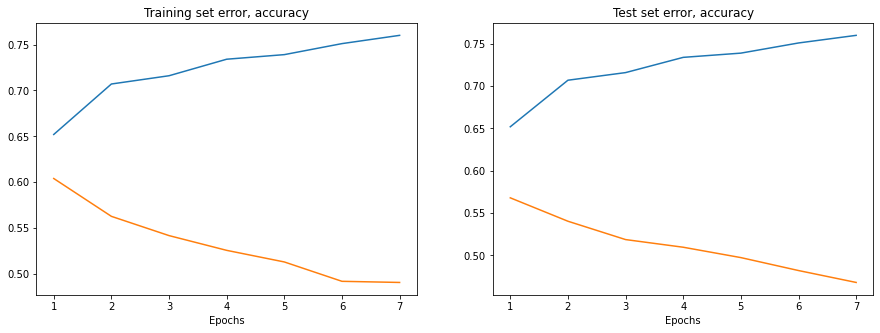

In [100]:
# The training set metrics.
y_training_error = [
    store_training_loss[i] / float(len(training_images))
    for i in range(len(store_training_loss))
]
x_training_error = range(1, len(store_training_loss) + 1)
y_training_accuracy = [
    store_training_accurate_pred[i] / float(len(training_images))
    for i in range(len(store_training_accurate_pred))
]
x_training_accuracy = range(1, len(store_training_accurate_pred) + 1)

# The test set metrics.
y_test_error = [
    store_test_loss[i] / float(len(test_images)) for i in range(len(store_test_loss))
]
x_test_error = range(1, len(store_test_loss) + 1)
y_test_accuracy = [
    store_training_accurate_pred[i] / float(len(training_images))
    for i in range(len(store_training_accurate_pred))
]
x_test_accuracy = range(1, len(store_test_accurate_pred) + 1)

# Display the plots.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].set_title("Training set error, accuracy")
axes[0].plot(x_training_accuracy, y_training_accuracy, label="Training set accuracy")
axes[0].plot(x_training_error, y_training_error, label="Training set error")
axes[0].set_xlabel("Epochs")
axes[1].set_title("Test set error, accuracy")
axes[1].plot(x_test_accuracy, y_test_accuracy, label="Test set accuracy")
axes[1].plot(x_test_error, y_test_error, label="Test set error")
axes[1].set_xlabel("Epochs")
plt.show()

_The training and testing error is shown above in the left and right
plots, respectively. As the number of Epochs increases, the total error
decreases and the accuracy increases._

The accuracy rates that your model reaches during training and testing may be somewhat plausible but you may also find the error rates to be quite high.

To reduce the error during training and testing, you can consider changing the simple loss function to, for example, categorical [cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy). Other possible solutions are discussed below.

## Next steps

You have learned how to build and train a simple feed-forward neural network from scratch using just NumPy to classify handwritten MNIST digits.

To further enhance and optimize your neural network model, you can consider one of a mixture of the following:
- Increase the training sample size from 1,000 to a higher number (up to 60,000).
- Use [mini-batches and reduce the learning rate](http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf).
- Alter the architecture by introducing more hidden layers to make the network [deeper](https://en.wikipedia.org/wiki/Deep_learning).
- Combine the [cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy) loss function with a [softmax](https://en.wikipedia.org/wiki/Softmax_function) activation function in the last layer.
- Introduce convolutional layers: replace the feedforward network with a [convolutional neural network](https://en.wikipedia.org/wiki/Convolutional_neural_network) architecture.
- Use a higher epoch size to train longer and add more regularization techniques, such as [early stopping](https://en.wikipedia.org/wiki/Early_stopping), to prevent [overfitting](https://en.wikipedia.org/wiki/Overfitting).
- Introduce a [validation set](https://en.wikipedia.org/wiki/Training,_validation,_and_test_sets) for an unbiased valuation of the model fit.
- Apply [batch normalization](https://en.wikipedia.org/wiki/Batch_normalization) for faster and more stable training.
- Tune other parameters, such as the learning rate and hidden layer size.

Building a neural network from scratch with NumPy is a great way to learn more about NumPy and about deep learning. However, for real-world applications you should use specialized frameworks — such as [PyTorch](https://pytorch.org/), [JAX](https://github.com/google/jax), [TensorFlow](https://www.tensorflow.org/guide/tf_numpy) or [MXNet](https://mxnet.apache.org) — that provide NumPy-like APIs, have built-in [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation) and GPU support, and are designed for high-performance numerical computing and machine learning.

Finally, when developing a machine learning model, you should think about potential ethical issues and apply practices to avoid or mitigate those:
- Document a trained model with a Model Card - see the [Model Cards for Model Reporting paper](https://doi.org/10.1145/3287560.3287596) by Margaret Mitchell et al..
- Document a dataset with a Datasheet - see the [Datasheets for Datasets paper](https://arxiv.org/abs/1803.09010)) by Timnit Gebru et al..
- Consider the impact of your model - who is affected by it, who does it benefit - see [the article](https://www.nature.com/articles/d41586-020-02003-2) and [talk](https://slideslive.com/38923453/the-values-of-machine-learning) by Pratyusha Kalluri.
- For more resources, see [this blog post by Rachel Thomas](https://www.fast.ai/2018/09/24/ai-ethics-resources/) and the [Radical AI podcast](https://www.radicalai.org/).

(Credit to [hsjeong5](https://github.com/hsjeong5/MNIST-for-Numpy) for demonstrating how to download MNIST without the use of external libraries.)